In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

# Loading Data

In [2]:
data = pd.read_csv('..\..\datasets\B2_Monthly_Rainfall.csv')
data.head()

,SUBDIVISIONS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,FLOOD
0,ANDAMAN & NICOBAR ISLANDS,2019,173.8,5.8,15.8,35.3,230.9,662.2,212.0,860.4,596.8,136.6,131.9,24.5,3086.0,YES
1,ANDAMAN & NICOBAR ISLANDS,2021,42.7,48.8,38.3,150.2,414.1,315.9,535.3,506.5,667.3,413.1,265.7,95.5,3493.4,YES
2,ANDAMAN & NICOBAR ISLANDS,2016,72.0,15.8,5.4,2.4,191.1,429.4,301.2,227.7,604.3,287.2,181.7,533.7,2851.9,NO
3,ANDAMAN & NICOBAR ISLANDS,2017,228.7,5.6,33.0,108.3,275.8,349.1,389.4,414.7,372.8,263.0,205.9,243.7,2890.0,NO
4,ANDAMAN & NICOBAR ISLANDS,2018,167.3,36.2,21.5,90.0,372.5,518.4,239.1,415.7,395.9,298.9,239.6,318.4,3113.5,YES


In [3]:
df = data.copy()
df['FLOOD'] = df['FLOOD'].replace({'YES': 1, 'NO': 0})
df['FLOOD'] = df['FLOOD'].fillna(0).astype(int)
df.sort_values(by=['YEAR'], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_14380\112302960.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['FLOOD'] = df['FLOOD'].replace({'YES': 1, 'NO': 0})


In [4]:
print("df shape :", df.shape, "\n")
df.info()
# df.describe()

df shape : (230, 16) 

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 2 to 174
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SUBDIVISIONS  230 non-null    object 
 1   YEAR          230 non-null    int64  
 2   JAN           230 non-null    float64
 3   FEB           230 non-null    float64
 4   MAR           230 non-null    float64
 5   APR           230 non-null    float64
 6   MAY           230 non-null    float64
 7   JUN           230 non-null    float64
 8   JUL           230 non-null    float64
 9   AUG           230 non-null    float64
 10  SEP           230 non-null    float64
 11  OCT           230 non-null    float64
 12  NOV           230 non-null    float64
 13  DEC           230 non-null    float64
 14  ANNUAL        230 non-null    float64
 15  FLOOD         230 non-null    int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 30.5+ KB


# Data Splitting & Window Sliding

In [5]:
X = df.drop(columns=['YEAR', 'FLOOD', 'SUBDIVISIONS'])
Y = df['FLOOD']

In [6]:
""" SLIDING WINDOW """
WINDOW_SIZE = 5
def create_dataset(X, Y):
    Xs, ys = [], []
    for i in range(len(X) - WINDOW_SIZE):
        v = X[i:(i + WINDOW_SIZE)]
        Xs.append(v)
        ys.append(Y.iloc[i + WINDOW_SIZE])
    return np.array(Xs), np.array(ys)

X_seq, Y_seq = create_dataset(X, Y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, Y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# --- Reshape for scaling ---
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# --- Initialize and fit scaler ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# --- Transform validation and test data ---
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# --- Reshape back to original 3D shape ---
X_train_seq = X_train_scaled.reshape(X_train.shape)
X_val_seq = X_val_scaled.reshape(X_val.shape)
X_test_seq = X_test_scaled.reshape(X_test.shape)

In [9]:
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_lstm_model(learning_rate=0.0001):
  model = Sequential()
  model.add(Input(shape=(WINDOW_SIZE, X.shape[1])))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(LSTM(16, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
  loss = BinaryCrossentropy()
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

model = build_lstm_model()
lr_scheduler = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=5,
  min_lr=1e-5,
  verbose=1
)
model.input_shape

(None, 5, 13)

In [10]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

tf.random.set_seed(42)
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.5377 - loss: 0.6957 - val_accuracy: 0.9444 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5238 - loss: 0.7239 - val_accuracy: 0.9444 - val_loss: 0.6842 - learning_rate: 1.0000e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6091 - loss: 0.6770 - val_accuracy: 0.9444 - val_loss: 0.6823 - learning_rate: 1.0000e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5353 - loss: 0.6878 - val_accuracy: 0.9444 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5806 - loss: 0.6821 - val_accuracy: 0.9444 - val_loss: 0.6782 - learning_rate: 1.0000e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5408 - loss: 0.7016 - val_accuracy: 0.9444 - val_loss: 0.6765 - learning_rate: 1.0000e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5322 - loss

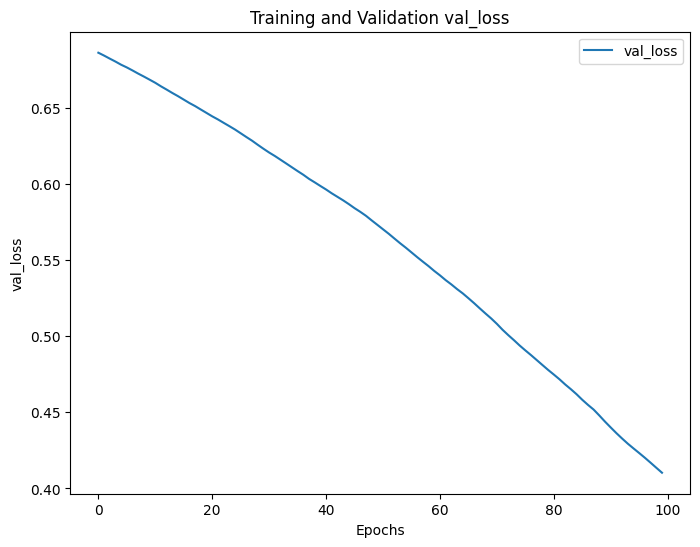

In [11]:
def plot_history(history, key):
  plt.figure()
  plt.plot(history.history[key], label=key)
  plt.xlabel('Epochs')
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.title(f"Training and Validation {key}")
  plt.show()

plot_history(history, 'val_loss')

In [12]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_seq)
y_pred = (y_pred >= 0.5).astype(int)

print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
Accuracy :  0.9111111111111111
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        41
           1       0.00      0.00      0.00         4

    accuracy                           0.91        45
   macro avg       0.46      0.50      0.48        45
weighted avg       0.83      0.91      0.87        45



In [13]:
import pandas as pd

# Flatten the arrays before creating Series
y_pred_flat = y_pred.ravel()  # or use y_pred.flatten()
y_test_flat = y_test.ravel()  # or use y_test.flatten()

# Create DataFrames and get value counts in one step
y_pred_counts = pd.Series(y_pred_flat).value_counts().reset_index(name='y_pred_count')
y_test_counts = pd.Series(y_test_flat).value_counts().reset_index(name='y_test_count')

# Rename 'index' to 'Value' for both DataFrames before merging
y_pred_counts.rename(columns={'index': 'Value'}, inplace=True)
y_test_counts.rename(columns={'index': 'Value'}, inplace=True)

# Merge the counts and align them by 'Value'
merged_counts = pd.merge(y_pred_counts, y_test_counts, on='Value', how='outer')

# Display the result
merged_counts.head()


,Value,y_pred_count,y_test_count
0,0,45.0,41
1,1,NaN,4


In [14]:
import os
os.makedirs('trained_model', exist_ok=True)
model.save(os.path.join('trained_model', 'DL_verB2_trained.keras'))

## Cross Validation

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5) # You can adjust the number of splits

fold_accuracies = []
fold_classification_reports = []
fold = 0
for train_index, test_index in tscv.split(X_seq):
    fold += 1
    print(f"Processing Fold {fold}...")

    # Split data into train and test for this fold
    X_train_fold, X_test_fold = X_seq[train_index], X_seq[test_index]
    y_train_fold, y_test_fold = Y_seq[train_index], Y_seq[test_index]

    # Further split the training fold into train and validation
    # We maintain the time series nature, so no shuffling
    # Split size for validation can be adjusted
    val_size = int(len(X_train_fold) * 0.1)
    X_train_inner, X_val_fold = X_train_fold[:-val_size], X_train_fold[-val_size:]
    y_train_inner, y_val_fold = y_train_fold[:-val_size], y_train_fold[-val_size:]


    # Reshape for scaling
    X_train_inner_reshaped = X_train_inner.reshape(-1, X_train_inner.shape[-1])
    X_val_fold_reshaped = X_val_fold.reshape(-1, X_val_fold.shape[-1])
    X_test_fold_reshaped = X_test_fold.reshape(-1, X_test_fold.shape[-1])

    # Initialize and fit scaler on the training data of this fold
    scaler_fold = MinMaxScaler()
    X_train_inner_scaled = scaler_fold.fit_transform(X_train_inner_reshaped)

    # Transform validation and test data using the scaler fitted on the training data
    X_val_fold_scaled = scaler_fold.transform(X_val_fold_reshaped)
    X_test_fold_scaled = scaler_fold.transform(X_test_fold_reshaped)

    # Reshape back to original 3D shape
    X_train_inner_seq = X_train_inner_scaled.reshape(X_train_inner.shape)
    X_val_fold_seq = X_val_fold_scaled.reshape(X_val_fold.shape)
    X_test_fold_seq = X_test_fold_scaled.reshape(X_test_fold.shape)


    # Build and compile a fresh model for each fold
    model_fold = build_lstm_model()

    # Define callbacks
    lr_scheduler_fold = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=0 # Set verbose to 0 for cleaner output
    )
    early_stopping_fold = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history_fold = model_fold.fit(
        X_train_inner_seq, y_train_inner,
        validation_data=(X_val_fold_seq, y_val_fold),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_fold, lr_scheduler_fold],
        verbose=0 # Set verbose to 0 for cleaner output
    )

    # Evaluate the model on the test set of this fold
    y_pred_fold = model_fold.predict(X_test_fold_seq)
    y_pred_fold = (y_pred_fold >= 0.5).astype(int)

    # Store accuracy & classification Report
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    fold_accuracies.append(accuracy)
    report_dict = classification_report(y_test_fold, y_pred_fold, zero_division=0, output_dict=True)
    fold_classification_reports.append(report_dict)

    # Print evaluation metrics for the fold
    print(f"--- Fold {fold} Results ---")
    print("Accuracy : ", accuracy)
    print("Classification Report:\n", classification_report(y_test_fold, y_pred_fold, zero_division=0))
    print("-" * 20)

Processing Fold 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
--- Fold 1 Results ---
Accuracy :  0.9459459459459459
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       0.00      0.00      0.00         2

    accuracy                           0.95        37
   macro avg       0.47      0.50      0.49        37
weighted avg       0.89      0.95      0.92        37

--------------------
Processing Fold 2...
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002337813FE20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of th

In [16]:
print("\n--- Cross-Validation Summary ---")
print(f"Average Accuracy  : {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")

# Convert each report dict into a DataFrame
reports_dfs = [pd.DataFrame(report).transpose() for report in fold_classification_reports]
# Concatenate all DataFrames into one with a MultiIndex (fold index, class label)
all_reports_df = pd.concat(reports_dfs, keys=range(len(reports_dfs)), axis=0)
# Group by class label (level=1) and compute mean of metrics
mean_report_df = all_reports_df.groupby(level=1).mean()

print("\nAverage Classification Report:")
print(mean_report_df)


--- Cross-Validation Summary ---
Average Accuracy  : 0.9081
Standard Deviation: 0.0367

Average Classification Report:
              precision    recall  f1-score    support
0              0.908108  1.000000  0.951453  33.600000
1              0.000000  0.000000  0.000000   3.400000
accuracy       0.908108  0.908108  0.908108   0.908108
macro avg      0.454054  0.500000  0.475726  37.000000
weighted avg   0.826004  0.908108  0.864764  37.000000
